In [ ]:
!pip install --upgrade pip
!pip install --upgrade setuptools wheel
!pip install --upgrade "mxnet<2.0.0"
!pip install --pre autogluon

In [ ]:
import pandas as pd
from collections import Counter

path = './drive/MyDrive/Materiale_Pellegrino_personal/CIDDS_Meta/CIDDS_Meta.csv'
dataset = pd.read_csv(path)

### ***PRE-ELABORAZIONE DATI***

In [ ]:
from sklearn.model_selection import train_test_split

# train 50% e test 50%
train, test = train_test_split(dataset, test_size=0.50)

In [ ]:
print('multilabel_Train: ', Counter(train['multilabel']))
print('multilabel_Test: ', Counter(test['multilabel']))

multilabel_Train:  Counter({'normal': 121745, 'dos': 58966, 'portScan': 18760, 'pingScan': 328, 'bruteForce': 201})
multilabel_Test:  Counter({'normal': 121618, 'dos': 58938, 'portScan': 18963, 'pingScan': 318, 'bruteForce': 163})


In [ ]:
from sklearn.preprocessing import LabelEncoder

y_train = LabelEncoder().fit_transform(train['multilabel'])
y_test = LabelEncoder().fit_transform(test['multilabel'])

# elimino le colonne dal dataset di test
test = test.drop('multilabel', axis=1)

# LabelEncoder in train di multilabel
target_index = train.columns.get_loc('multilabel')
train.iloc[:, target_index] = y_train

# La colonna Flows presenta tutti valori 1 -> inutile
test = test.drop('Flows', axis=1)
train = train.drop('Flows', axis=1)

In [ ]:
print('Encod_multilabel_train: ', Counter(y_train))
print('Encod_multilabel_test: ', Counter(y_test))

Encod_multilabel_train:  Counter({2: 121745, 1: 58966, 4: 18760, 3: 328, 0: 201})
Encod_multilabel_test:  Counter({2: 121618, 1: 58938, 4: 18963, 3: 318, 0: 163})


In [ ]:
target_dict = {'bruteForce' : 0,
               'dos' : 1,
               'normal' : 2,
               'pingScan' : 3,
               'portScan' : 4}

### ***MODEL***

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pprint
import random
from autogluon.tabular import TabularPredictor
import mxnet as mx

In [ ]:
label = 'multilabel'

train_df = train
test_df = test

print('Number of training samples:', len(train_df))
print('Number of test samples:', len(test_df))

Number of training samples: 200000
Number of test samples: 200000


In [ ]:
test_df

,Duration,Proto,Packets,Bytes,Flags,Tos
270020,0.004,TCP,5,479,.AP.SF,0
251018,0.000,TCP,1,100,.AP...,32
144858,0.005,TCP,4,272,.A..SF,0
233220,0.000,UDP,1,75,......,0
79835,0.004,TCP,4,272,.A..SF,0
...,...,...,...,...,...,...
358557,0.000,TCP,1,304,.AP...,32
396222,0.000,TCP,1,66,.A....,32
106811,0.002,TCP,4,272,.A..SF,0
390200,0.000,TCP,2,163,.AP..F,32


In [ ]:
train_df

,Duration,Proto,Packets,Bytes,Flags,Tos,multilabel
337846,0.000,TCP,1,54,.A.R..,0,4
370831,0.236,TCP,6,3583,.AP.S.,32,2
136197,0.002,TCP,4,272,.A..SF,0,1
267246,0.000,TCP,1,66,.A....,32,2
17088,0.000,TCP,1,74,.A..S.,32,2
...,...,...,...,...,...,...,...
353910,0.000,TCP,1,66,.A....,0,2
8656,0.000,TCP,1,70,.A..S.,0,2
359579,0.005,TCP,3,206,.A..SF,0,1
88355,0.002,TCP,3,206,.A..SF,0,1


In [ ]:
from autogluon.tabular import TabularPredictor
predictor = TabularPredictor(label=label)

predictor.fit(train_df, hyperparameters='multimodal')

No path specified. Models will be saved in: "AutogluonModels/ag-20210618_110817/"
	Consider setting `time_limit` to ensure training finishes within an expected duration or experiment with a small portion of `train_data` to identify an ideal `presets` and `hyperparameters` configuration.
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/ag-20210618_110817/"
AutoGluon Version:  0.2.1b20210618
Train Data Rows:    200000
Train Data Columns: 6
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == int, but few unique label-values observed).
	5 unique label values:  [4, 2, 1, 3, 0]
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Train Data Class Count: 5
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                 model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0             LightGBM     0.9964       0.018347    5.227355                0.018347           5.227355            1       True          1
1  WeightedEnsemble_L2     0.9964       0.019228    5.601071                0.000882           0.373716            2       True          7
2        LightGBMLarge     0.9964       0.024436    4.036435                0.024436           4.036435            1       True          6
3           LightGBMXT     0.9964       0.032561    5.499688                0.032561           5.499688            1       True          2
4              XGBoost     0.9960       0.014454    4.265618                0.014454           4.265618            1       True          4
5       NeuralNetMXNet     0.9960       0.246669  590.905835                0.246669         590.905835 

{'leaderboard':                  model  score_val  ...  can_infer  fit_order
 0             LightGBM     0.9964  ...       True          1
 1  WeightedEnsemble_L2     0.9964  ...       True          7
 2        LightGBMLarge     0.9964  ...       True          6
 3           LightGBMXT     0.9964  ...       True          2
 4              XGBoost     0.9960  ...       True          4
 5       NeuralNetMXNet     0.9960  ...       True          5
 6             CatBoost     0.9928  ...       True          3
 
 [7 rows x 9 columns],
 'max_stack_level': 2,
 'model_best': 'WeightedEnsemble_L2',
 'model_fit_times': {'CatBoost': 8.112269401550293,
  'LightGBM': 5.227355003356934,
  'LightGBMLarge': 4.03643536567688,
  'LightGBMXT': 5.499687671661377,
  'NeuralNetMXNet': 590.9058349132538,
  'WeightedEnsemble_L2': 0.373715877532959,
  'XGBoost': 4.265617847442627},
 'model_hyperparams': {'CatBoost': {'allow_writing_files': False,
   'eval_metric': 'Accuracy',
   'iterations': 10000,
   'learni

### ***PREDICTION***

In [ ]:
""" Per la predizione e la valutazione uso solo la Rete Neurale tra tutti i modelli addestrati """

models = predictor.get_model_names()
nn_name = models[4]
nn_name

'NeuralNetMXNet'

In [ ]:
# predizione usando solo NeuralNetMXNet
y_pred = predictor.predict(test_df, model=nn_name)
y_pred

270020    1
251018    2
144858    1
233220    2
79835     1
         ..
358557    2
396222    2
106811    1
390200    2
253465    2
Name: multilabel, Length: 200000, dtype: int64

13 sec

### ***EVALUATION NEURALNET***


In [ ]:
print('Test:', Counter(y_test))
print('Pred:', Counter(y_pred))

Test: Counter({2: 121618, 1: 58938, 4: 18963, 3: 318, 0: 163})
Pred: Counter({2: 121733, 1: 58933, 4: 19162, 3: 145, 0: 27})


In [ ]:
# Matrice di confusione, accuracy, classification_report
from sklearn.metrics import *

# y_test è la variabile che contiene i valori effettivi
# y_pred contiene i valori predetti dal modello
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

acc = accuracy_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
recall = recall_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
# non presente nella libreria, calcolo mediante formula
f2 = (1+2**2)*((precision*recall)/((2**2*precision)+recall))

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:72: FutureWarning: Pass display_labels={'bruteForce': 0, 'dos': 1, 'normal': 2, 'pingScan': 3, 'portScan': 4} as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


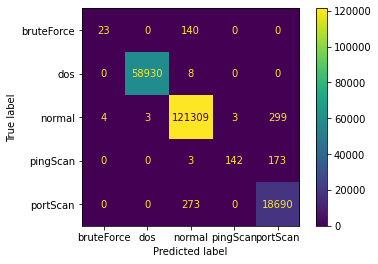

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(cm, target_dict)
disp.plot()

In [ ]:
mcm = multilabel_confusion_matrix(y_test, y_pred)
print(mcm)

[[[199833      4]
  [   140     23]]

 [[141059      3]
  [     8  58930]]

 [[ 77958    424]
  [   309 121309]]

 [[199679      3]
  [   176    142]]

 [[180565    472]
  [   273  18690]]]


In [ ]:
FP = cm.sum (axis = 0) - np.diag (cm) 
FN = cm.sum (axis = 1) - np.diag (cm) 
TP = np.diag (cm) 
TN = cm.sum () - (FP + FN + TP)

print('True positive: ', TP)
print('True negative: ', TN)
print('False positive: ', FP)
print('False negative: ', FN)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print('True positive rate: ', TPR)
print('True negative rate: ', TNR)
print('False positive rate: ', FPR)
print('False negative rate: ', FNR)

True positive:  [    23  58930 121309    142  18690]
True negative:  [199833 141059  77958 199679 180565]
False positive:  [  4   3 424   3 472]
False negative:  [140   8 309 176 273]
True positive rate:  [0.14110429 0.99986426 0.99745926 0.44654088 0.98560354]
True negative rate:  [0.99997998 0.99997873 0.99459059 0.99998498 0.9973928 ]
False positive rate:  [2.00163133e-05 2.12672442e-05 5.40940522e-03 1.50238880e-05
 2.60720184e-03]
False negative rate:  [8.58895706e-01 1.35735858e-04 2.54074232e-03 5.53459119e-01
 1.43964563e-02]


In [ ]:
print(cm)

[[    23      0    140      0      0]
 [     0  58930      8      0      0]
 [     4      3 121309      3    299]
 [     0      0      3    142    173]
 [     0      0    273      0  18690]]


In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.85      0.14      0.24       163
           1       1.00      1.00      1.00     58938
           2       1.00      1.00      1.00    121618
           3       0.98      0.45      0.61       318
           4       0.98      0.99      0.98     18963

    accuracy                           1.00    200000
   macro avg       0.96      0.71      0.77    200000
weighted avg       1.00      1.00      1.00    200000



In [ ]:
print('Accuracy: ', acc)
print('Precision_weighted: ', precision)
print('Recall_weighted: ', recall)
print('mcc: ', mcc)
print('f2: ', f2)

Accuracy:  0.99547
Precision_weighted:  0.995377873102525
Recall_weighted:  0.99547
mcc:  0.9915188454250821
f2:  0.9954515732562461
